In [9]:
import json, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.sparse import csr_matrix

In [24]:
# Read in the JSON data
data_stream = ""
with open("challenge_set.json", "r") as f:
    data_stream = f.read()
data_set = json.loads(data_stream)


# Grab unique track/artist pairs
track_uris = set()
for i,j in enumerate(data_set["playlists"]):
    if len(j["tracks"]) == 100:
        for track in j["tracks"]:
            track_uris.add((track["track_name"], track["artist_name"], track["track_uri"]))
unique_tracks = list(track_uris)


uri_to_title_artist_map = {x[2]: (x[0], x[1]) for x in unique_tracks}
for i,(j,k) in enumerate(uri_to_title_artist_map.items()):
    if i > 20: break
    print(j,k)

spotify:track:2aksifNn5ph8igDOkPBA02 ('Love On The Brain', 'Rihanna')
spotify:track:3eR3lWuvQqOzhTn91nbRCa ('Something That I Want', 'Grace Potter')
spotify:track:51iNZz9l1U9ul0p87jbrbr ('Hole in My Head', 'Dixie Chicks')
spotify:track:2JdhhL0CzxiAKCvEg9EeLf ('Shut Up and Kiss Me', 'Mary Chapin Carpenter')
spotify:track:40T9vgCE3W4Y6QePIkQBEm ('Hillbilly Bone', 'Blake Shelton')
spotify:track:2VO1hW4kBSUC5l7RMWX4KN ('Fountain Of Sorrow - Live', 'Jackson Browne')
spotify:track:73b8U6817JH9cCoG3wXMdv ("Stepped On My J'z", 'Nelly')
spotify:track:3kuAtUUfV3s6SGncgkN6fx ('For The Road', 'Tyga')
spotify:track:3Fg4SlOiqKDodVJbAM2Gut ('Suck You Dry - 2008 Remastered Version', 'Mudhoney')
spotify:track:0UD2tx4S1FzKK8vsZl4LX6 ('Y Ahora Resulta', 'Felix Manuel')
spotify:track:0Q9f1NBvKCC37V4oJVEgCh ('Breakdown', 'Seether')
spotify:track:0wvIGFIgbyz4JNwQhZgTv2 ('Rooster', 'Alice In Chains')
spotify:track:75JFxkI2RXiU7L9VXzMkle ('The Scientist', 'Coldplay')
spotify:track:0VjkjJ1vNCrbdk0EhM6Phw ('10 

In [11]:
df = pd.read_csv("all_downloaded_data.csv")
df = df.drop("Unnamed: 0", axis=1)
df = df.set_index('uri')
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
uri,,,,,,,,,,,,,,,,,
spotify:track:38uqMByifM0mkjcTbejlyR,0.375,0.294,8,-8.751,1,0.0329,0.928000,0.000000,0.1900,0.125,95.128,audio_features,38uqMByifM0mkjcTbejlyR,https://api.spotify.com/v1/tracks/38uqMByifM0m...,https://api.spotify.com/v1/audio-analysis/38uq...,161573,4
spotify:track:4kOTDj4SiZPkW1p96WMDNv,0.950,0.803,1,-4.195,1,0.1510,0.145000,0.000000,0.0748,0.860,117.000,audio_features,4kOTDj4SiZPkW1p96WMDNv,https://api.spotify.com/v1/tracks/4kOTDj4SiZPk...,https://api.spotify.com/v1/audio-analysis/4kOT...,213066,4
spotify:track:1c9LBfX0klXJscJAYDI0Ea,0.758,0.501,0,-7.051,1,0.0589,0.252000,0.000000,0.1910,0.397,78.042,audio_features,1c9LBfX0klXJscJAYDI0Ea,https://api.spotify.com/v1/tracks/1c9LBfX0klXJ...,https://api.spotify.com/v1/audio-analysis/1c9L...,194147,4
spotify:track:59iNA6gwthoTJ6IgpBGGHW,0.534,0.749,6,-5.562,0,0.0749,0.077600,0.000001,0.0906,0.671,179.975,audio_features,59iNA6gwthoTJ6IgpBGGHW,https://api.spotify.com/v1/tracks/59iNA6gwthoT...,https://api.spotify.com/v1/audio-analysis/59iN...,212160,4
spotify:track:4QCng4MDyUhEZ730Ma2Rjp,0.674,0.744,11,-5.196,1,0.2740,0.023800,0.000000,0.3300,0.624,154.086,audio_features,4QCng4MDyUhEZ730Ma2Rjp,https://api.spotify.com/v1/tracks/4QCng4MDyUhE...,https://api.spotify.com/v1/audio-analysis/4QCn...,262400,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:3SI9uxzQCSEfj7V1Qvf7nU,0.394,0.641,1,-7.645,1,0.3730,0.247000,0.000004,0.6560,0.193,165.120,audio_features,3SI9uxzQCSEfj7V1Qvf7nU,https://api.spotify.com/v1/tracks/3SI9uxzQCSEf...,https://api.spotify.com/v1/audio-analysis/3SI9...,389800,4
spotify:track:5DrRvw69AtJ0PwVpEp22NO,0.810,0.562,1,-4.593,1,0.1300,0.050700,0.000000,0.1220,0.179,119.892,audio_features,5DrRvw69AtJ0PwVpEp22NO,https://api.spotify.com/v1/tracks/5DrRvw69AtJ0...,https://api.spotify.com/v1/audio-analysis/5DrR...,241091,4
spotify:track:4zYBVaPx3EfZIUoNWFtdov,0.563,0.697,8,-6.127,0,0.0439,0.000575,0.000000,0.2240,0.653,148.040,audio_features,4zYBVaPx3EfZIUoNWFtdov,https://api.spotify.com/v1/tracks/4zYBVaPx3EfZ...,https://api.spotify.com/v1/audio-analysis/4zYB...,247408,4


Example of uri_to_title_artist_map usage

In [12]:
uri_to_title_artist_map["spotify:track:38uqMByifM0mkjcTbejlyR"]

('Where Do I Go From Here', 'Pocahontas')

In [13]:
playlist_idcs = []
for i,j in enumerate(data_set["playlists"]):
    if len(j["tracks"]) == 100:
        playlist_idcs.append(i) 
print(len(unique_tracks))
print(len(playlist_idcs), "total playlists")
print(df.shape[0], "total songs")

53552
2000 total playlists
53550 total songs


In [14]:
membership_mtx = np.load("playlist_membership_data.npy")
membership_lbls = np.load("playlist_membership_labels.npy")
print("Avg song is in", np.mean(np.sum(membership_mtx, axis=1)), "playlists")

# Remove mostercat songs that don't exist.
filtered_mtx = membership_mtx
filtered_lbls = membership_lbls
for idx, i in enumerate(filtered_lbls):
    if i[2] == "spotify:track:5CmMyiq4um2aFhiLZ1rPWo":
        filtered_mtx = np.delete(filtered_mtx, idx, axis=0)
        filtered_lbls = np.delete(filtered_lbls, idx, axis=0)
        
for idx, i in enumerate(filtered_lbls):
    if i[2] == "spotify:track:4mjgNE8R31AzxWfPNGtVMf":
        filtered_mtx = np.delete(filtered_mtx, idx, axis=0)
        filtered_lbls = np.delete(filtered_lbls, idx, axis=0)

# This is a super sparse matrix, so use csr format to save space.
test = csr_matrix(filtered_mtx)
frequency_csr_mtx = test @ test.T
print(test.shape)
print(frequency_csr_mtx.shape)

Avg song is in 3.695492231849417 playlists
(53550, 2000)
(53550, 53550)


In [15]:
dense_data = frequency_csr_mtx.todense()
dense_data.shape

(53550, 53550)

In [16]:
# Create Dev and Test Data
dataset_size = dense_data.shape[0]
test_dev_idcs = np.random.choice(dataset_size, replace=False, size=int(0.3*dataset_size))
test_dev_idcs.shape

dev_idcs = np.random.choice(test_dev_idcs.shape[0], replace=False, size=int((2/3) * test_dev_idcs.shape[0]))
selected_dev_labels = filtered_lbls[test_dev_idcs[dev_idcs]]
dev_data = df.loc[selected_dev_labels[:, 2]]
dev_data = dev_data.iloc[:, 0:10].to_numpy()
dev_labels = np.array(np.max(dense_data[dev_idcs], axis=1).T)[0]
print("dev")
print(dev_data.shape)
print(dev_labels.shape)

test_idcs = np.delete(test_dev_idcs, dev_idcs, axis=0)
selected_test_labels = filtered_lbls[test_idcs]
test_data = df.loc[selected_test_labels[:, 2]]
test_data = test_data.iloc[:, 0:10].to_numpy()
test_labels = np.array(np.max(dense_data[test_idcs], axis=1).T)[0]
print("test")
print(test_data.shape)
print(test_labels.shape)

# Create Training Data
train_idcs = np.delete(np.arange(df.shape[0]), test_dev_idcs, axis=0)
selected_test_lbls = np.delete(filtered_lbls, test_dev_idcs, axis=0)
train_data = df.loc[selected_test_lbls[:,2]]
train_data = train_data.iloc[:, 0:10].to_numpy()
train_labels = np.array(np.max(np.delete(dense_data, test_dev_idcs, axis=0), axis=1).T)[0]
print("train")
print(train_data.shape)
print(train_labels.shape)

dev
(10710, 10)
(10710,)
test
(5355, 10)
(5355,)
train
(37485, 10)
(37485,)


In [17]:
def normalize(data):
    col_means = data.mean(axis=0)
    col_std = data.std(axis=0)
    return (data - col_means) / col_std

train_data = normalize(train_data)
dev_data = normalize(dev_data)
test_data = normalize(test_data)

In [18]:
lr = 0.01
batch_size = 100
epochs = 100

In [19]:
class RecommenderNet(torch.nn.Module):
    ### Implement your model's structure and input/filter/output dimensions
    def __init__(self, num_songs):
        super().__init__()
        self.lm1 = torch.nn.Linear(10, 1000)
#         self.lm2 = torch.nn.Linear(100, 1000)
        self.lm3 = torch.nn.Linear(1000, num_songs)
        
        self.num_songs = num_songs

    def forward(self, x):
        x = torch.tanh(self.lm1(x))
#         x = torch.tanh(self.lm2(x))
        x = self.lm3(x)
        return x

In [20]:
number_of_songs = df.shape[0] 

model = RecommenderNet(number_of_songs)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_steps = []
train_losses = []
dev_steps = []
dev_losses = []

for step in range(epochs):
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    x = torch.from_numpy(train_data[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.float32))
    idcs = train_idcs[i]
    
    prediction_idcs = model(x)
    pred_freq = np.array(dense_data[idcs, prediction_idcs.argmax(axis=1)])[0]
    test = torch.from_numpy(pred_freq.astype(np.float32))
    test.requires_grad = True
    loss = F.mse_loss(test, y) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_steps.append(step)
    train_losses.append(loss.item())
    
    if step % 10 == 0:
        dev_i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
        dev_d = torch.from_numpy(dev_data[dev_i].astype(np.float32))
        dev_l = torch.from_numpy(dev_labels[dev_i].astype(np.float32))
        dev_idc = dev_idcs[dev_i]
        
        dev_pred = model(dev_d)
        pred_freq = np.array(dense_data[dev_idc, dev_pred.argmax(axis=1)])[0]
        dev = torch.from_numpy(pred_freq.astype(np.float32))
        dev_loss = F.mse_loss(dev, dev_l)
        
        dev_steps.append(step)
        dev_losses.append(dev_loss.item())
        
        print(f"{(step/epochs) * 100:0.1f}% {loss.item()}, {dev_loss.item()}")
    

0.0% 152.16000366210938, 80.19580078125
10.0% 84.41999816894531, 91.38880157470703
20.0% 65.0999984741211, 88.37660217285156
30.0% 217.1300048828125, 87.9739990234375
40.0% 44.0, 84.24759674072266
50.0% 96.58999633789062, 71.22540283203125
60.0% 46.63999938964844, 83.2394027709961
70.0% 67.37000274658203, 85.00800323486328
80.0% 58.7599983215332, 78.00980377197266
90.0% 13.020000457763672, 77.46299743652344


Text(0.5, 0, 'step')

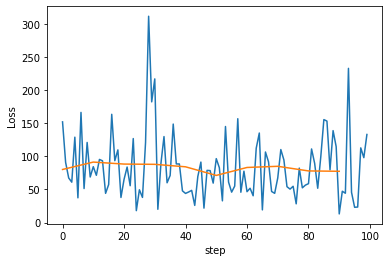

In [21]:
plt.plot(train_steps, train_losses)
plt.plot(dev_steps, dev_losses)
plt.ylabel("Loss")
plt.xlabel("step")